# libraddask Template for Radiative Transfer

This notebook demonstrates the use of the libraddask library.

It calculates the radiative transfer calculations for the Sentinel 3 overpass over
Roodeplaat (\ang{25;37;29}S, \ang{28;21;39}E) on Sunday 2016-06-05.

## Running libRadtran

For the purpose of this example the following scenario is used (adapt for your case):
- server is called `nimbus` with IP address 146.64.246.94
- the work is done from user account dgriffith
- the Python and dask packages are set up in the `mordevpy37` conda environment.

Setting up the Dask environment is described in the libraddask report in the `libraddask/docs/report folder`.

The instructions here describe the use of the nimbus server (146.64.246.94).

1. If working off-site, use a VPN client to connect to the same network as used by the server.  Dask requires that your local PC must have an IP number in the same subnetwork as the server.  Some VPNs do not provide an IP number on the same subnetwork and such VPN clients will not work with Dask.

2. Using a remote terminal client on your local computer, open three terminal windows on the server: 
    - a  terminal for general use, 
    - a terminal for the Dask scheduler, and
    - a terminal for the Dask workers.

3. In the scheduler terminal activate the conda environment with the Dask packages and then start the scheduler.

        conda activate mordevpy37
        dask-scheduler
        
   The scheduler responds with something like this:
   
        (base) dgriffith@nimbus:~$ conda activate mordevpy37
        (mordevpy37) dgriffith@nimbus:~$ dask-scheduler
        distributed.scheduler - INFO - -----------------------------------------------
        distributed.scheduler - INFO - Local Directory:    /tmp/scheduler-ay08oqkc
        distributed.scheduler - INFO - -----------------------------------------------
        distributed.scheduler - INFO - Clear task state
        distributed.scheduler - INFO -   Scheduler at:  tcp://146.64.246.94:8786
        distributed.scheduler - INFO -   dashboard at:                     :8787

    Observe the scheduler URI: `tcp://146.64.246.94:8786`, this must be used in the next step to set up the workers.
    
4. In the worker terminal change to the `bin` folder in the libRadtran installation folder and activate the conda environment with the Dask packages and then start the worker, using the scheduler URI and setting the required number of processors on the cluster :

        cd libRadtran/libRadtran-2.0.3/bin    
        conda activate mordevpy37    
        dask-worker tcp://146.64.246.94:8786 --nprocs 8    
        
    This should start eight workers, each with a different port number (not all detail shown below):
    
        (base) dgriffith@nimbus:~$ cd libRadtran/libRadtran-2.0.3/bin
        (base) dgriffith@nimbus:~/libRadtran/libRadtran-2.0.3/bin$ conda activate mordevpy37
        (mordevpy37) dgriffith@nimbus:~/libRadtran/libRadtran-2.0.3/bin$ dask-worker tcp://146.64.246.94:8786 --nprocs 8
        distributed.nanny - INFO -         Start Nanny at: 'tcp://146.64.246.94:33671'
        distributed.nanny - INFO -         Start Nanny at: 'tcp://146.64.246.94:46725'
        distributed.nanny - INFO -         Start Nanny at: 'tcp://146.64.246.94:42509'
        distributed.nanny - INFO -         Start Nanny at: 'tcp://146.64.246.94:42983'
        distributed.nanny - INFO -         Start Nanny at: 'tcp://146.64.246.94:43735'
        distributed.nanny - INFO -         Start Nanny at: 'tcp://146.64.246.94:36947'
        distributed.nanny - INFO -         Start Nanny at: 'tcp://146.64.246.94:40075'
        distributed.nanny - INFO -         Start Nanny at: 'tcp://146.64.246.94:40495'
        ...
        distributed.worker - INFO -       Start worker at:  tcp://146.64.246.94:36533
        distributed.worker - INFO -          Listening to:  tcp://146.64.246.94:36533
        distributed.worker - INFO -          dashboard at:        146.64.246.94:43069
        distributed.worker - INFO - Waiting to connect to:   tcp://146.64.246.94:8786
        distributed.worker - INFO - -------------------------------------------------
        distributed.worker - INFO -               Threads:                          4
        distributed.worker - INFO -                Memory:                    4.21 GB
        distributed.worker - INFO -       Local Directory: /home/dgriffith/libRadtran/libRadtran-2.0.3/bin/dask-worker-space/worker-_0o0qta1
        distributed.worker - INFO - -------------------------------------------------
        distributed.worker - INFO -         Registered to:   tcp://146.64.246.94:8786
        distributed.worker - INFO - -------------------------------------------------
        distributed.core - INFO - Starting established connection
        ...
        distributed.worker - INFO -       Start worker at:  tcp://146.64.246.94:46597
        distributed.worker - INFO -          Listening to:  tcp://146.64.246.94:46597
        distributed.worker - INFO -          dashboard at:        146.64.246.94:33737
        distributed.worker - INFO - Waiting to connect to:   tcp://146.64.246.94:8786
        distributed.worker - INFO - -------------------------------------------------
        distributed.worker - INFO -               Threads:                          4
        distributed.worker - INFO -                Memory:                    4.21 GB
        distributed.worker - INFO -       Local Directory: /home/dgriffith/libRadtran/libRadtran-2.0.3/bin/dask-worker-space/worker-n0anjq00
        distributed.worker - INFO - -------------------------------------------------
        distributed.core - INFO - Starting established connection
        distributed.worker - INFO -         Registered to:   tcp://146.64.246.94:8786
        distributed.worker - INFO - -------------------------------------------------
        distributed.core - INFO - Starting established connection


5. Run the code that activates the client in the local PC (see the code further down below). This should send the serialised data to the scheduler:

        distributed.scheduler - INFO - Register worker <Worker 'tcp://146.64.246.94:33437', name: tcp://146.64.246.94:33437, memory: 0, processing: 0>
        distributed.scheduler - INFO - Starting worker compute stream, tcp://146.64.246.94:33437
        distributed.core - INFO - Starting established connection
        distributed.scheduler - INFO - Receive client connection: Client-1ed95fc0-8076-11ea-8700-cfd8862f98eb
        distributed.core - INFO - Starting established connection
        distributed.scheduler - INFO - Receive client connection: Client-27b067b0-8076-11ea-8700-cfd8862f98eb
        distributed.core - INFO - Starting established connection

    The scheduler will send the serialised data to the workers, which will execute the tasks:
    
        Running AerAng600to900nm
        Running AerAng650to800nm
        
If the libRadtran execution was successful the tasks should complete and the data returned to the client.


## Prepare for Python

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime
import pytz

from dask.distributed import Client # For contacting the dask scheduler
import libraddask.rad.librad as librad

import pprint
pp = pprint.PrettyPrinter(indent=4)

%matplotlib inline

## Set up a Scenario or Case

Populate an instance of the `librad.Case` class.

Note that this code will be executed in the  
`/home/dgriffith/libRadtran/libRadtran-2.0.3/bin/`  
folder, so the paths must be relative to this executing location.  The paths defined here has no bearing to any folder on the local computer.


In [2]:
# Create a blank libRadtran case

S3 = librad.Case(casename='AerAng600to900nm')

# Set revision
revision = '00A'

# Choose basic atmospheric profile
atmos_profile = '../data/atmmod/afglmw.dat'
S3.set_option('atmosphere_file', atmos_profile)  # mid-latitude winter standard atmosphere

# Change to the Thuillier spectrum and set wavelength range appropriately
solar_toa_file = '../data/solar_flux/Solar_irradiance_Thuillier_2002.txt'
solar_toa_file = '../data/solar_flux/kurudz_1.0nm.dat'

# Choose start and stop wavelengths and minimum edge margin in nm
wv_minimum_range = [[385.0, -2.0], [955.0, 2.0]]
S3.set_option('source solar', solar_toa_file)
S3.set_option('wavelength', 600.0, 900.0)

# Set up dates and times
overpass_datetime = datetime.datetime(2016, 6, 5, 7, 42, 31, tzinfo=pytz.utc)  # Overpass date and time down to second
overpass_datestr = overpass_datetime.strftime('%Y%m%d')
# Get the day of year
day_of_year = int(overpass_datetime.strftime('%j'))

results_folder = 'ResultsS3on' + overpass_datestr + 'Rev' + revision

# Choose solver
S3.set_option('rte_solver disort')

# Set ground altitude
S3.set_option('altitude', 1.225)  # ground altitude in km above sea level

# Set ground albedo
S3.set_option('albedo 0.5')

# Set up aerosol model
S3.set_option('aerosol_default')
aot_wv = np.array([440, 500, 675, 870], dtype=np.float)  # MicroTOPS measurement wavelengths
aot = np.array([0.703, 0.615, 0.362, 0.206])  # MicroTOPS measurements
# Fit Angstrom law to data
alpha, beta = librad.angstrom_law_fit(aot_wv, aot)
# Fit King Byrne formula
alpha_0, alpha_1, alpha_2 = librad.king_byrne_formula_fit(aot_wv, aot)
S3.set_option('aerosol_angstrom', alpha, beta)

# Set up viewing and solar geometry. Note that these angles are taken from the S3 product and special
# care has to be taken when putting geometry information into libRadtran
OAA = 104.01066  # deg. Observation azimuth angle (presumably relative to north through east, satellite from dam)
OZA = 14.151356  # deg. Observation zenith angle (satellite zenith angle as seen from the dam)
SAA = 38.719933  # deg. Solar azimuth angle (presumably relative to north through east)
SZA = 59.316036  # deg. Solar zenith angle

S3.set_option('sza', SZA)  # deg. This one is straightforward
# Now when entering solar and observation zenith angles, it is necessary to provide the azimuth of light propagation
# rather than the azimuth of the view direction, which is 180 deg different
#S3.set_option('phi0', 180.0 - SAA)  # solar radiation propagation azimuth from north through east
#S3.set_option('phi', OAA)  # This is the azimuth of the satellite as seen from the target - also azimuth of light propgation
#S3.set_option('umu', np.cos(np.deg2rad(OZA))) # For downward-looking (upward propagating), check that umu is positive

S3.set_option('verbose')  # Will produce a lot of diagnostic output on stderr

#S3.set_option('zout boa')  # Set altitude of output data
S3.purge = False  # Prevent purging of output files


In [3]:
print(S3)

atmosphere_file ../data/atmmod/afglmw.dat
source solar ../data/solar_flux/kurudz_1.0nm.dat
wavelength 600.0 900.0
rte_solver disort
altitude 1.225
albedo 0.5
aerosol_default 
aerosol_angstrom 1.6848887536371142 0.18175118840581214
sza 59.316036
verbose 


In [4]:
# To copy a case it is necessary to use the deepcopy operation
# If you use S3b = S3, both variables point to the same copy
import copy
S3b = copy.deepcopy(S3)
#S3b.name = 'S3toTOAon20160605b'
S3b.name = 'AerAng650to800nm'
S3b.set_option('wavelength', 650.0, 800.0)
# S3b.set_option('aerosol_visibility', 5.0)

In [5]:
S3b

atmosphere_file ../data/atmmod/afglmw.dat
source solar ../data/solar_flux/kurudz_1.0nm.dat
wavelength 650.0 800.0
rte_solver disort
altitude 1.225
albedo 0.5
aerosol_default 
aerosol_angstrom 1.6848887536371142 0.18175118840581214
sza 59.316036
verbose 

In [6]:
#  dask Client method with scheduler serverURI (IP and port)
serverURI = '146.64.246.94:8786'
client = Client(serverURI)

number_of_processes = len(client.scheduler_info()['workers'])
print(f'Number of workers: {number_of_processes}')
print(f'Client cores: {client.ncores()} ')

# pp.pprint(client.get_versions(check=True))


Number of workers: 8
Client cores: {'tcp://146.64.246.94:34141': 4, 'tcp://146.64.246.94:34371': 4, 'tcp://146.64.246.94:36467': 4, 'tcp://146.64.246.94:38881': 4, 'tcp://146.64.246.94:38989': 4, 'tcp://146.64.246.94:40421': 4, 'tcp://146.64.246.94:41607': 4, 'tcp://146.64.246.94:43819': 4} 


In [7]:
# do a run on the server
futuresRad = client.map(librad.Case.run, [S3, S3b])
# Gather results. This will wait for completion of all tasks.
S3List = client.gather(futuresRad)    

# check the return values
librad.check_uvspec_run_success(S3List)

All runs successful.


In [8]:
S3 = S3List[0]
S3b = S3List[1]

In [9]:
# Check for any errors by printing the return code and anything written to stderr
print('Return Codes : ', S3.run_return_code, ' and ', S3b.run_return_code)
# S3.stderr

Return Codes :  0  and  0


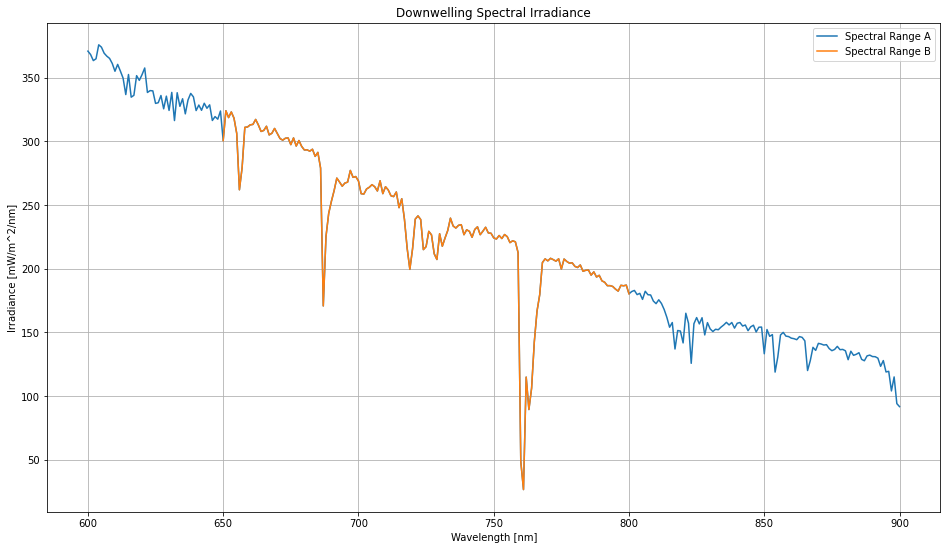

In [10]:
plt.figure(figsize=(16,9))
plt.plot(S3.wvl, S3.edn, S3b.wvl, S3b.edn)
plt.xlabel('Wavelength [nm]')
plt.ylabel('Irradiance [mW/m^2/nm]')
plt.title('Downwelling Spectral Irradiance')
plt.legend(['Spectral Range A', 'Spectral Range B'])
plt.grid()
plt.savefig('ednAerAng.pdf')

In [11]:
# Check the quality of the Angstrom Law and King-Byrne formula fits
the_wv = np.arange(350.0, 950.0, 10.0)  # Pick a wavelength range
the_aot = librad.king_byrne_formula(the_wv, alpha_0, alpha_1, alpha_2)  # Calculate King-Byrne 
aot_ang = librad.angstrom_law(the_wv, alpha, beta)  # Calculate Angstrom Law

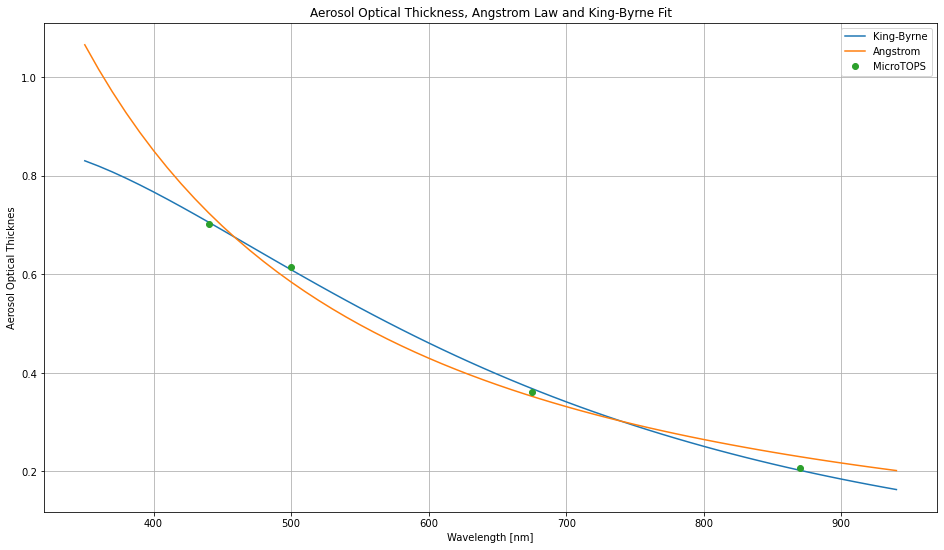

In [12]:
# Plot Angstrom Law and King-Byrne fitted curves with MicroTOPS measurements
plt.figure(figsize=(16,9))
plt.plot(the_wv, the_aot, the_wv, aot_ang, aot_wv, aot, 'o')
plt.xlabel('Wavelength [nm]')
plt.ylabel('Aerosol Optical Thicknes')
plt.title('Aerosol Optical Thickness, Angstrom Law and King-Byrne Fit')
plt.legend(['King-Byrne', 'Angstrom', 'MicroTOPS'])
plt.grid()


## Shutting down the Client

When the client is no longer required, shut it down.

In [ ]:
client.shutdown()

In [14]:
# to get software versions
# https://github.com/rasbt/watermark
# An IPython magic extension for printing date and time stamps, version numbers, and hardware information. 
# you only need to do this once
# !pip install watermark

%load_ext watermark
%watermark -v -m -p numpy,matplotlib,datetime,pytz,dask,dask.distributed,libraddask -g 

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
CPython 3.7.6
IPython 7.13.0

numpy 1.18.1
matplotlib 3.2.1
datetime unknown
pytz 2019.3
dask 2.12.0
dask.distributed 2.12.0
libraddask 0.1.1

compiler   : MSC v.1916 64 bit (AMD64)
system     : Windows
release    : 7
machine    : AMD64
processor  : Intel64 Family 6 Model 94 Stepping 3, GenuineIntel
CPU cores  : 8
interpreter: 64bit
Git hash   : 57c3d6341eb9c9e38dae9a712e5dc375f6297c8d
